# NLP with Cards Against Humanity
__Goals:__  
1. __Joke Generator:__ Given a randomly chosen question, pick answers, use this to label my data _(Word2Vec and Cosine Similarity, future: use Google's Gensim)_
2. Topic modeling on the Answer Cards _(NMF & CV / LSA & TFIDF)_
3. Clustering _(K-means and DBScan)_
4. Generate new answer cards - Natural Language Generation _(RNN, future: Bag of words, Markov Chain)_

__This Notebook contains:__
1. Extract the Data
2. NLP Preprocessing
3. Word2Vec (for Joke Generator)
4. Topic Modeling
5. Clustering
6. NLG/RNN please see Notesbooks Part II & III 

## Extract the data

In [7]:
import urllib.request, json 
import urllib
import json
import pandas as pd
import os
from collections import Counter
%config InlineBackend.figure_format='svg'

In [2]:
os.chdir('/Users/bellepeng/Desktop/Metis/Projects/NLP_CardsAgainstHumanity/data')

In [3]:
with open("cah.json") as json_data:
    cah = json.load(json_data)

In [4]:
print(cah.keys())
print("how many blackCards?", len(cah['blackCards']))
print("how many Base black?",len(cah['Base']['black']))
print("how many whiteCards?",len(cah['whiteCards']))
print("how many Base white?",len(cah['Base']['white']))
print(cah['Base']['name'])
print(cah['order'])

dict_keys(['blackCards', 'whiteCards', 'Base', 'CAHe1', 'CAHe2', 'CAHe3', 'CAHe4', 'CAHe5', 'CAHe6', 'greenbox', 'order'])
how many blackCards? 295
how many Base black? 90
how many whiteCards? 1155
how many Base white? 460
Base Set
['Base', 'CAHe1', 'CAHe2', 'CAHe3', 'CAHe4', 'CAHe5', 'CAHe6', 'greenbox']


In [5]:
keys=['Base', 'CAHe1', 'CAHe2', 'CAHe3', 'CAHe4', 'CAHe5', 'CAHe6', 'greenbox']
count_w=[]
for k in range(len(keys)):
    count_w.append(len(cah[keys[k]]['white']))

count_b=[]
for k in range(len(keys)):
    count_b.append(len(cah[keys[k]]['black']))

print("check total white cards:", sum(count_w))
print("check total black cards:", sum(count_b))

check total white cards: 1155
check total black cards: 295


In [93]:
whiteCards=cah['whiteCards']
print(len(whiteCards))
print(type(whiteCards))
whiteCards[:5]

1155
<class 'list'>


['Coat hanger abortions.',
 'Man meat.',
 'Autocannibalism.',
 'Vigorous jazz hands.',
 'Flightless birds.']

In [94]:
blackCards=[x['text'] for x in cah['blackCards']]
print(len(blackCards))
print(type(blackCards))
blackCards[:5]

295
<class 'list'>


["Why can't I sleep at night?",
 "I got 99 problems but _ ain't one.",
 "What's a girl's best friend?",
 "What's that smell?",
 'This is the way the world ends / This is the way the world ends / Not with a bang but with _.']

In [95]:
blackCards.pop(74)
blackCards.pop(131)
whiteCards.pop(614)

'Me.'

## NLP Preprocessing

In [96]:
from __future__ import print_function
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from collections import Counter
from operator import itemgetter

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [97]:
# Remove Stop Words
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', 'got', 'br', 'getting', '&reg']
print(len(stop))
# itemsToRemove=['you', 'yourself', 'your', 'me', 'myself', 'our']
# stop = [x for x in stop if x not in itemsToRemove]
print(len(stop))

punctuations=['.', ',', '(', ')', "'", '"']

189
189


In [98]:
os.chdir('/Users/bellepeng/Desktop/Metis/Work/tools')
from nlp import fixContractions 

In [6]:
import re
# re.sub(r'', '', text)

In [99]:
# Clean the text for Word2Vec
def clean_text(text):
    text=text.replace('&reg;', '')
    text=text.replace('&Reg;', '')
    text=text.replace('&', '')
    text=text.replace('amp', '')
    text=text.replace("'s'", '')
    text=text.replace('_', '')
    text=text.replace('`', '')
    lemmatize = WordNetLemmatizer()
    text = fixContractions(text)
    tokens = word_tokenize(text)
    clean_text = [lemmatize.lemmatize(token.lower().strip(), pos='a') for token in tokens]
    clean_text = [x for x in clean_text if x not in stop]
    return ' '.join(clean_text)

In [100]:
allCards = whiteCards+blackCards
cleaned_all=[clean_text(i) for i in allCards]
cleaned_w = [clean_text(i) for i in whiteCards]
cleaned_b = [clean_text(i) for i in blackCards]
print(cleaned_w[135])
print(cleaned_b[100])

tempur-pedic swedish sleep systemtrade ;
learned hard way cheer grieving friend


In [101]:
# Tokenize for other NLP
tokenized_w = [word_tokenize(i) for i in cleaned_w]
tokenized_b = [word_tokenize(i) for i in cleaned_b]
print(len(tokenized_w))
print(len(tokenized_b))

tokenized_w = list(filter(lambda x: len(x)!=0, tokenized_w))
tokenized_b = list(filter(lambda x: len(x)!=0, tokenized_b))
print(len(tokenized_w))
print(len(tokenized_b))
tokenized_w[:3]

1154
293
1153
293


[['coat', 'hanger', 'abortions'], ['man', 'meat'], ['autocannibalism']]

In [102]:
# Vectorize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=stop, lowercase=False)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=stop, lowercase=False)

cv_w = [count_vectorizer.fit_transform(i) for i in tokenized_w]
tfidf_w = [tfidf_vectorizer.fit_transform(i) for i in tokenized_w]

cv_b = [count_vectorizer.fit_transform(i) for i in tokenized_b]
tfidf_b = [tfidf_vectorizer.fit_transform(i) for i in tokenized_b]

## Word2Vec
Calculate the Question Word Vecs ad Answer Word Vecs, then compute the distance

In [53]:
import gensim  # using skip-gram
from gensim.models import Word2Vec

In [54]:
def find_vec(text_list):
    text_str=[x.split() for x in text_list]
    model = gensim.models.Word2Vec(text_str, window=1, min_count=1, workers=1, sg=1)
    return model
    # list(model.wv.vocab.items())[:5]
    # model['love']
    #print(model.wv.most_similar('smegma'))

In [55]:
wordVec = find_vec((cleaned_w+cleaned_b))

In [56]:
# For each White Card, find the sum of the word vectors
cardVec_w = [sum(wordVec[x]) for x in tokenized_w]
print(len(cardVec_w))
cardVec_w_dict = dict(zip(whiteCards, cardVec_w))

1153


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [57]:
def cardVec_list(wordVec, tokenized_words):
    eachCard=[]
    for i in range(len(tokenized_words)):
        try:
            eachCard.append(wordVec[tokenized_words[i]])
        except:
            eachCard.append(0)   
    return eachCard

In [58]:
cardVec_list_b=[]
for i in range(len(tokenized_b)):
    cardVec_list_b.append(cardVec_list(wordVec, tokenized_b[i]))
    
len(cardVec_list_b)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


293

In [59]:
cardVec_b = [sum(x) for x in cardVec_list_b]
cardVec_b_dict = dict(zip(blackCards, cardVec_b))
# cardVec_b_dict.keys()

In [60]:
# cardVec_w_dict.keys()

In [61]:
distances=[]
for question in range(len(tokenized_b)):
    X = cardVec_b[question]
    
    answers=[]
    for answer in range(len(tokenized_w)):
        Z = [X, cardVec_w[answer]]
        answers.append(cosine_similarity(Z)[0][1])
    
    distances.append(answers)      

In [62]:
print(len(distances[0]))
len(distances)

1153


293

In [63]:
# import pickle
# with open('CAH_distances.pkl', 'wb') as picklefile:
#     pickle.dump(distances, picklefile)

I got 99 problems but _ ain't one.  
Min: Being a motherfucking sorcerer.  
Max: One thousand Slim Jims.  

Why can't I sleep at night?  
Min: Friendly fire.  
Max: Bees?  

In [34]:
for q in range(len(blackCards)):
    print(blackCards[q])
    max_answer = distances[q].index(max(distances[q]))
    answer_25 = distances[q].index(np.percentile(distances[q], 25))
    med_answer = distances[q].index(np.median(distances[q]))
    answer_75 = distances[q].index(np.percentile(distances[q], 75))
    min_answer = distances[q].index(min(distances[q]))
    
    print("Most Expected Answer:", whiteCards[max_answer])
    print("Answer 2:", whiteCards[answer_25])
    print("Answer 3:", whiteCards[med_answer])
    print("Answer 4:", whiteCards[answer_75])
    print("Least Expected Answer:", whiteCards[min_answer])
    print("\n")

Why can't I sleep at night?
Most Expected Answer: Salsa Night at Dave's Cantina.
Answer 2: Justin Bieber.
Answer 3: Getting really high.
Answer 4: Beating your wives.
Least Expected Answer: The passage of time.


I got 99 problems but _ ain't one.
Most Expected Answer: One of them big-city Jew lawyers.
Answer 2: Giant sperm from outer space.
Answer 3: Being popular and good at sports.
Answer 4: Chipotle.
Least Expected Answer: The entire Internet.


What's a girl's best friend?
Most Expected Answer: Bees?
Answer 2: Assassinating the president.
Answer 3: Synergistic management solutions.
Answer 4: Santa Claus.
Least Expected Answer: A medium horchata.


What's that smell?
Most Expected Answer: Bees?
Answer 2: An overwhelming variety of cheeses.
Answer 3: Smallpox blankets.
Answer 4: A robust mongoloid.
Least Expected Answer: Genghis Khan's DNA.


This is the way the world ends / This is the way the world ends / Not with a bang but with _.
Most Expected Answer: A Native American who solv

Most Expected Answer: Becoming the President of the United States.
Answer 2: Licking things to claim them as your own.
Answer 3: Pretending to care.
Answer 4: A passionate Latino lover.
Least Expected Answer: Sudden penis loss.


_. It's a trap!
Most Expected Answer: BATMAN!!!
Answer 2: Scrubbing under the folds.
Answer 3: Grunting for ten minutes and then peeing sand.
Answer 4: Scrotum tickling.
Least Expected Answer: Doing the right thing.


How am I maintaining my relationship status?
Most Expected Answer: My relationship status.
Answer 2: Dying.
Answer 3: 10 Incredible Facts About the Anus.
Answer 4: My inner demons.
Least Expected Answer: The euphoric rush of strangling a drifter.


What will I bring back in time to convince people that I am a powerful wizard?
Most Expected Answer: Fucking a corpse back to life.
Answer 2: The miracle of childbirth.
Answer 3: Figuring out how to have sex with a dolphin.
Answer 4: Every ounce of charisma left in Mick Jagger's tired body.
Least Expec

Most Expected Answer: The World of Warcraft.
Answer 2: Moon people.
Answer 3: Making the penises kiss.
Answer 4: Being sexually attracted to children.
Least Expected Answer: Seizing control of the means of production.


Step 1: _. Step 2: _. Step 3: Profit.
Most Expected Answer: An uppercut.
Answer 2: Political correctness.
Answer 3: Justin Bieber.
Answer 4: Oncoming traffic.
Least Expected Answer: A hot mess.


Here is the church<br>Here is the steeple<br>Open the doors<br>And there is _.
Most Expected Answer: An all-midget production of Shakespeare's <i>Richard III</i>.
Answer 2: Passive-aggressive Post-it notes.
Answer 3: Demonic possession.
Answer 4: A big, beautiful mouth packed to the brim with sparkling teeth.
Least Expected Answer: Object permanence.


How did I lose my virginity?
Most Expected Answer: Bees?
Answer 2: Overthrowing the democratically-elected government of Chile.
Answer 3: A tribe of warrior women.
Answer 4: Brunch.
Least Expected Answer: Screaming like a maniac.

This is your captain speaking. Fasten your seatbelts and prepare for _.
Most Expected Answer: Genetically engineered super-soldiers.
Answer 2: Prematurely ejaculating like a total loser.
Answer 3: Screaming like a maniac.
Answer 4: Masturbation.
Least Expected Answer: Hope.


My mom freaked out when she looked at my browser history and found _.com/_.
Most Expected Answer: Quiche.
Answer 2: Oil!
Answer 3: Genghis Khan's DNA.
Answer 4: Darth Vader.
Least Expected Answer: The Rev. Dr. Martin Luther King, Jr.


The Five Stages of Grief: denial, anger, bargaining, _, acceptance.
Most Expected Answer: Beating your wives.
Answer 2: Crippling debt.
Answer 3: Being John Malkovich.
Answer 4: Blood farts.
Least Expected Answer: Comprehensive immigration reform.


Members of New York's social elite are paying thousands of dollars just to experience _.
Most Expected Answer: Toni Morrison's vagina.
Answer 2: The Chinese gymnastics team.
Answer 3: Crying and shitting and eating spaghetti.
Answer 4: A

Most Expected Answer: Chugging a lava lamp.
Answer 2: Licking things to claim them as your own.
Answer 3: Jizz.
Answer 4: Apologizing.
Least Expected Answer: A magic hippie love cloud.


2 AM in the city that never sleeps. The door swings open and <i>she</i> walks in, legs up to here. Something in her eyes tells me she's looking for _.
Most Expected Answer: An all-midget production of Shakespeare's <i>Richard III</i>.
Answer 2: Fingering.
Answer 3: Party Mexicans.
Answer 4: The clitoris.
Least Expected Answer: The best, deepest quotes from The Dark Knight.


As king, how will I keep the peasants in line?
Most Expected Answer: Getting your dick stuck in a Chinese finger trap with another dick.
Answer 2: The Big Bang.
Answer 3: A micropenis.
Answer 4: Bingeing and purging.
Least Expected Answer: Some shit-hot guitar licks.


Oprah's book of the month is "_ For _: A Story of Hope."
Most Expected Answer: Dining with cardboard cutouts of the cast of "Friends."
Answer 2: Western standards of

Answer 3: Alcoholism.
Answer 4: Anal fissures like you wouldn't believe.
Least Expected Answer: Denying the Holocaust.


Yo' mama so fat she _!
Most Expected Answer: A sad fat dragon with no friends.
Answer 2: Turning the rivers red with the blood of infidels.
Answer 3: A long business meeting with no obvious purpose.
Answer 4: The Land of Chocolate.
Least Expected Answer: A gender identity that can only be conveyed through slam poetry.


Well if _ is good enough for _, it's good enough for me.
Most Expected Answer: A good sniff.
Answer 2: A for-real lizard that spits blood from its eyes.
Answer 3: Erectile dysfunction.
Answer 4: A pile of squirming bodies.
Least Expected Answer: Rising from the grave.


Hi, this is Jim from accounting. We noticed a $1,200 charge labeled "_". Can you explain?
Most Expected Answer: The color "puce".
Answer 2: A surprising amount of hair.
Answer 3: How awesome I am.
Answer 4: A pile of squirming bodies.
Least Expected Answer: AIDS monkeys.


Do you lack 

Most Expected Answer: Fucking me good and taking me to Red Lobster&reg;.
Answer 2: Oil!
Answer 3: Whomsoever let the dogs out.
Answer 4: Mommy and daddy fighting all the time.
Least Expected Answer: The female orgasm.


Congratulations! You have been selected for our summer internship program. While we are unable to offer a salary, we can offer you _.
Most Expected Answer: Michael Jackson.
Answer 2: Crushing the patriarchy.
Answer 3: My first kill.
Answer 4: The Dance of the Sugar Plum Fairy.
Least Expected Answer: Our baby.


Dance like there's nobody watching, love like you'll never be hurt, and live like you're _.
Most Expected Answer: Getting laid like all the time.
Answer 2: Getting caught by the police and going to jail.
Answer 3: A creepy child singing a nursery rhyme.
Answer 4: The secret to truly resilient hair.
Least Expected Answer: Passable transvestites.


Errbody in the club _.
Most Expected Answer: Making the penises kiss.
Answer 2: Some sort of Asian.
Answer 3: Our new 

Most Expected Answer: Puppies!
Answer 2: Nipple blades.
Answer 3: An unforgettable quincea&ntilde;era.
Answer 4: The complex geopolitical quagmire that is the Middle East.
Least Expected Answer: Jean-Claude Van Damme.


We do not shake with our left hands in this country. That is the hand we use for _.
Most Expected Answer: A low standard of living.
Answer 2: Getting high with mom.
Answer 3: Lance Armstrong's missing testicle.
Answer 4: Deflowering the princess.
Least Expected Answer: Our baby.


Well if _ is a crime, then lock me up!
Most Expected Answer: Quivering jowls.
Answer 2: Two shitty kids and a garbage husband.
Answer 3: Being nine years old.
Answer 4: Getting killed and dragged up a tree by a leopard.
Least Expected Answer: Too much cocaine.


Well, shit. My eyes ain't so good, but I'll eat my own boot if that ain't _!
Most Expected Answer: A good sniff.
Answer 2: Dying of dysentery.
Answer 3: Informing you that I am a registered sex offender.
Answer 4: Reverse cowgirl.
Leas

In [77]:
# for q in range(len(blackCards)):
#     max_answer = distances[q].index(max(distances[q]))
#     answer_25 = distances[q].index(np.percentile(distances[q], 25))
#     med_answer = distances[q].index(np.median(distances[q]))
#     answer_75 = distances[q].index(np.percentile(distances[q], 75))
#     min_answer = distances[q].index(min(distances[q]))
    
#     print(blackCards[q])
#     print(whiteCards[max_answer])
#     print("\n")
#     print(blackCards[q])
#     print(whiteCards[answer_25])
#     print("\n")
#     print(blackCards[q])
#     print(whiteCards[med_answer])
#     print("\n")
#     print(blackCards[q])
#     print(whiteCards[answer_75])
#     print("\n")
#     print(blackCards[q])
#     print(whiteCards[min_answer])
#     print("\n")

Why can't I sleep at night?
Salsa Night at Dave's Cantina.


Why can't I sleep at night?
Turning 32.


Why can't I sleep at night?
Wearing glasses and sounding smart.


Why can't I sleep at night?
Shitting all over the floor like a bad, bad girl.


Why can't I sleep at night?
The passage of time.


I got 99 problems but _ ain't one.
Intimacy problems.


I got 99 problems but _ ain't one.
A web of lies.


I got 99 problems but _ ain't one.
The Google.


I got 99 problems but _ ain't one.
A sea of troubles.


I got 99 problems but _ ain't one.
A rival dojo.


What's a girl's best friend?
Bees?


What's a girl's best friend?
Happy daddies with happy sandals.


What's a girl's best friend?
Opening your mouth to talk and a big penis fops out.


What's a girl's best friend?
Seeing things from Hitler's perspective


What's a girl's best friend?
A medium horchata.


What's that smell?
Bees?


What's that smell?
Putting an entire peanut butter and jelly sandwich into the VCR.


What's that smel

When I am a billionaire, I shall erect a 50-foot statue to commemorate _.
Darth Vader.


When I am a billionaire, I shall erect a 50-foot statue to commemorate _.
The Land of Chocolate.


When I am a billionaire, I shall erect a 50-foot statue to commemorate _.
Lumberjack fantasies.


When I am a billionaire, I shall erect a 50-foot statue to commemorate _.
A manhole.


When I am a billionaire, I shall erect a 50-foot statue to commemorate _.
A really cool hat.


What's the new fad diet?
Bees?


What's the new fad diet?
Twenty cheerleaders laughing at your tiny penis.


What's the new fad diet?
Mommy and daddy fighting all the time.


What's the new fad diet?
Pretending to care.


What's the new fad diet?
Insatiable bloodlust.


When I am the President of the United States, I will create the Department of _.
Becoming the President of the United States.


When I am the President of the United States, I will create the Department of _.
Filling a man's anus with concrete.


When I am the 

When I was tripping on acid, _ turned into _.
Being John Malkovich.


When I was tripping on acid, _ turned into _.
Farting a huge shit out of my pussy.


When I was tripping on acid, _ turned into _.
Roland the Farter, flatulist to the king.


When I was tripping on acid, _ turned into _.
Bill Clinton, naked on a bearskin rug with a saxophone.


When I was tripping on acid, _ turned into _.
Eating all of the cookies before the AIDS bake-sale.


What's the next superhero/sidekick duo?
GoGurt&reg;.


What's the next superhero/sidekick duo?
Antidepressants.


What's the next superhero/sidekick duo?
Samuel L. Jackson.


What's the next superhero/sidekick duo?
Lumberjack fantasies.


What's the next superhero/sidekick duo?
The economy.


Dear Abby,<br><br>I'm having some trouble with _ and would like your advice.
An all-midget production of Shakespeare's <i>Richard III</i>.


Dear Abby,<br><br>I'm having some trouble with _ and would like your advice.
Jazz.


Dear Abby,<br><br>I'm having s

When all else fails, I can always masturbate to _.
Girls that always be textin'.


When all else fails, I can always masturbate to _.
Spring break!


When all else fails, I can always masturbate to _.
Grandma.


When all else fails, I can always masturbate to _.
Licking things to claim them as your own.


When all else fails, I can always masturbate to _.
Laying an egg.


An international tribunal has found _ guilty of _.
Nickelback.


An international tribunal has found _ guilty of _.
Sniffing glue.


An international tribunal has found _ guilty of _.
Getting hilariously gang-banged by the Blue Man Group.


An international tribunal has found _ guilty of _.
Getting your dick stuck in a Chinese finger trap with another dick.


An international tribunal has found _ guilty of _.
A cooler full of organs.


In its new tourism campaign, Detroit proudly proclaims that it has finally eliminated _.
Teenage pregnancy.


In its new tourism campaign, Detroit proudly proclaims that it has finally 

Everyone down on the ground! We don't want to hurt anyone. We're just here for _.
Grave robbing.


Everyone down on the ground! We don't want to hurt anyone. We're just here for _.
My huge penis and substantial fortune.


Everyone down on the ground! We don't want to hurt anyone. We're just here for _.
Britney Spears at 55.


Everyone down on the ground! We don't want to hurt anyone. We're just here for _.
A slightly shittier parallel universe.


Everyone down on the ground! We don't want to hurt anyone. We're just here for _.
Being John Malkovich.


The healing process began when I joined a support group for victims of _.
Nothing.


The healing process began when I joined a support group for victims of _.
Helplessly giggling at the mention of Hutus and Tutsis.


The healing process began when I joined a support group for victims of _.
Hot lettuce.


The healing process began when I joined a support group for victims of _.
A mating display.


The healing process began when I joined a s


_. Awesome in theory, kind of a mess in practice.
Masturbation.


As part of his contract, Prince won't perform without _ in his dressing room.
Scrubbing under the folds.


As part of his contract, Prince won't perform without _ in his dressing room.
Filling every orifice with butterscotch pudding.


As part of his contract, Prince won't perform without _ in his dressing room.
Another goddamn vampire movie.


As part of his contract, Prince won't perform without _ in his dressing room.
A man in yoga pants with a ponytail and feather earrings.


As part of his contract, Prince won't perform without _ in his dressing room.
The day the birds attacked.


Man, this is bullshit. Fuck _.
Bullshit.


Man, this is bullshit. Fuck _.
Critical thinking.


Man, this is bullshit. Fuck _.
Getting abducted by Peter Pan.


Man, this is bullshit. Fuck _.
Poor life choices.


Man, this is bullshit. Fuck _.
Weapons-grade plutonium.


Dear Leader Kim Jong-un,<br>our village praises your infinite wisdom wi

Do the Dew &reg; with our most extreme flavor yet! Get ready for Mountain Dew _!
BATMAN!!!


Do the Dew &reg; with our most extreme flavor yet! Get ready for Mountain Dew _!
Mental illness.


Do the Dew &reg; with our most extreme flavor yet! Get ready for Mountain Dew _!
Content.


Do the Dew &reg; with our most extreme flavor yet! Get ready for Mountain Dew _!
The safe word.


Do the Dew &reg; with our most extreme flavor yet! Get ready for Mountain Dew _!
Bees?


Armani suit: $1,000. Dinner for two at that swanky restaurant: $300. The look on her face when you surprise her with _: priceless.
Gladiatorial combat.


Armani suit: $1,000. Dinner for two at that swanky restaurant: $300. The look on her face when you surprise her with _: priceless.
10 Incredible Facts About the Anus.


Armani suit: $1,000. Dinner for two at that swanky restaurant: $300. The look on her face when you surprise her with _: priceless.
Loud, scary thunder.


Armani suit: $1,000. Dinner for two at that swanky r


This is America. If you don't work hard, you don't succeed. I don't care if you're black, white, purple, or _.
Hospice care.


This is America. If you don't work hard, you don't succeed. I don't care if you're black, white, purple, or _.
An empowered woman.


This is America. If you don't work hard, you don't succeed. I don't care if you're black, white, purple, or _.
Eating an albino.


This is America. If you don't work hard, you don't succeed. I don't care if you're black, white, purple, or _.
Crystal meth.


This is America. If you don't work hard, you don't succeed. I don't care if you're black, white, purple, or _.
Fucking me good and taking me to Red Lobster&reg;.


You Won't Believe These 15 Hilarious _ Bloopers!
Getting this party started!


You Won't Believe These 15 Hilarious _ Bloopers!
Blackula.


You Won't Believe These 15 Hilarious _ Bloopers!
An uninterrupted history of imperialism and exploitation.


You Won't Believe These 15 Hilarious _ Bloopers!
A gassy antelope.



Coming to Red Lobster&reg; this month, _.
Fucking me good and taking me to Red Lobster&reg;.


Coming to Red Lobster&reg; this month, _.
A greased-up Matthew McConaughey.


Coming to Red Lobster&reg; this month, _.
GoGurt&reg;.


Coming to Red Lobster&reg; this month, _.
Participating.


Coming to Red Lobster&reg; this month, _.
Heartwarming orphans.


Congratulations! You have been selected for our summer internship program. While we are unable to offer a salary, we can offer you _.
BATMAN!!!


Congratulations! You have been selected for our summer internship program. While we are unable to offer a salary, we can offer you _.
Take-backsies.


Congratulations! You have been selected for our summer internship program. While we are unable to offer a salary, we can offer you _.
A constant need for validation.


Congratulations! You have been selected for our summer internship program. While we are unable to offer a salary, we can offer you _.
Water.


Congratulations! You have been select

She's a lady in the streets, _ in the sheets.
Leprosy.


She's a lady in the streets, _ in the sheets.
Stranger danger.


She's a lady in the streets, _ in the sheets.
A black friend.


She's a lady in the streets, _ in the sheets.
Eating Tom Selleck's mustache to gain his powers.


She's a lady in the streets, _ in the sheets.
Horrifying laser hair removal accidents.


She's just one of the guys, you know? She likes beer, and football, and _.
Guys who don't call.


She's just one of the guys, you know? She likes beer, and football, and _.
Sucking all the milk out of a yak.


She's just one of the guys, you know? She likes beer, and football, and _.
God.


She's just one of the guys, you know? She likes beer, and football, and _.
The hardworking Mexican.


She's just one of the guys, you know? She likes beer, and football, and _.
Nunchuck moves.


Son, take it from someone who's been around the block a few times. Nothin' puts her in the mood like _.
Bathing in moonsblood and dancing ar

In [ ]:
# f = open('CAH_predicted_answers2.txt','w')
# for q in range(len(blackCards)):
#     max_answer = distances[q].index(max(distances[q]))
#     answer_25 = distances[q].index(np.percentile(distances[q], 25))
#     med_answer = distances[q].index(np.median(distances[q]))
#     answer_75 = distances[q].index(np.percentile(distances[q], 75))
#     min_answer = distances[q].index(min(distances[q]))
    
#     f.write(% blackCards[q])
#     f.write(% whiteCards[min_answer])
#     f.write("/n")
    
#     f.write(% blackCards[q])
#     f.write(% whiteCards[answer_25])
#     f.write("/n")
    
#     f.write(% blackCards[q])
#     f.write(% whiteCards[med_answer])
#     f.write("/n")
    
#     f.write(% blackCards[q])
#     f.write(% whiteCards[answer_75])
#     f.write("/n")
    
#     f.write(% blackCards[q])
#     f.write(% whiteCards[max_answer])
#     f.write("/n")
# f.close()

In [82]:
# f = open('test.txt','w')
# for i in range(5):
#     f.write("" % i)
#     f.write("/n")
# f.close()

TypeError: not all arguments converted during string formatting

### Generate a Labeled Dataset using W2V

In [27]:
# Generating a Labeled Dataset: Create a matrix of distances
w2v_pred_matrix=[]
for q in range(len(blackCards)):
    answer_min = distances[q].index(min(distances[q]))
    answer_25 = distances[q].index(np.percentile(distances[q], 25))
    answer_med = distances[q].index(np.median(distances[q]))
    answer_75 = distances[q].index(np.percentile(distances[q], 75))
    answer_max = distances[q].index(max(distances[q]))
    answers = [answer_min, answer_25, answer_med, answer_75, answer_max]
    w2v_pred_matrix.append(answers)

In [64]:
# Generating a Labeled Dataset: Create a matrix of words
w2v_pred_words=[]
for q in range(len(blackCards)):    
    words_min = tokenized_w[distances[q].index(min(distances[q]))]
    w2v_pred_words.append([tokenized_b[q], words_min])
        
    words_25 = tokenized_w[distances[q].index(np.percentile(distances[q], 25))]
    w2v_pred_words.append([tokenized_b[q], words_25])
    
    words_med = tokenized_w[distances[q].index(np.median(distances[q]))]
    w2v_pred_words.append([tokenized_b[q], words_med])
        
    words_75 = tokenized_w[distances[q].index(np.percentile(distances[q], 75))]
    w2v_pred_words.append([tokenized_b[q], words_75])
        
    words_max = tokenized_w[distances[q].index(max(distances[q]))]
    w2v_pred_words.append([tokenized_b[q], words_max])
    
print(len(w2v_pred_words))

1465


In [65]:
w2v_pred_words[:15]

[[['sleep', 'night', '?'], ['passage', 'time']],
 [['sleep', 'night', '?'], ['turning', '32']],
 [['sleep', 'night', '?'], ['wearing', 'glasses', 'sounding', 'smart']],
 [['sleep', 'night', '?'],
  ['shitting', 'floor', 'like', 'bad', 'bad', 'girl']],
 [['sleep', 'night', '?'], ['salsa', 'night', 'dave', "'s", 'cantina']],
 [['99', 'problems', 'one'], ['rival', 'dojo']],
 [['99', 'problems', 'one'], ['web', 'lies']],
 [['99', 'problems', 'one'], ['google']],
 [['99', 'problems', 'one'], ['sea', 'troubles']],
 [['99', 'problems', 'one'], ['intimacy', 'problems']],
 [['girl', "'s", 'best', 'friend', '?'], ['medium', 'horchata']],
 [['girl', "'s", 'best', 'friend', '?'],
  ['happy', 'daddies', 'happy', 'sandals']],
 [['girl', "'s", 'best', 'friend', '?'],
  ['opening', 'mouth', 'talk', 'big', 'penis', 'fops']],
 [['girl', "'s", 'best', 'friend', '?'],
  ['seeing', 'things', 'hitler', "'s", 'perspective']],
 [['girl', "'s", 'best', 'friend', '?'], ['bees', '?']]]

In [66]:
# from itertools import chain
# w2v_pred_words_flat = [list(chain.from_iterable(x)) for x in w2v_pred_words]
# print(len(w2v_pred_words_flat))
# w2v_pred_words_flat[:15]

1465


[['sleep', 'night', '?', 'passage', 'time'],
 ['sleep', 'night', '?', 'turning', '32'],
 ['sleep', 'night', '?', 'wearing', 'glasses', 'sounding', 'smart'],
 ['sleep', 'night', '?', 'shitting', 'floor', 'like', 'bad', 'bad', 'girl'],
 ['sleep', 'night', '?', 'salsa', 'night', 'dave', "'s", 'cantina'],
 ['99', 'problems', 'one', 'rival', 'dojo'],
 ['99', 'problems', 'one', 'web', 'lies'],
 ['99', 'problems', 'one', 'google'],
 ['99', 'problems', 'one', 'sea', 'troubles'],
 ['99', 'problems', 'one', 'intimacy', 'problems'],
 ['girl', "'s", 'best', 'friend', '?', 'medium', 'horchata'],
 ['girl', "'s", 'best', 'friend', '?', 'happy', 'daddies', 'happy', 'sandals'],
 ['girl',
  "'s",
  'best',
  'friend',
  '?',
  'opening',
  'mouth',
  'talk',
  'big',
  'penis',
  'fops'],
 ['girl',
  "'s",
  'best',
  'friend',
  '?',
  'seeing',
  'things',
  'hitler',
  "'s",
  'perspective'],
 ['girl', "'s", 'best', 'friend', '?', 'bees', '?']]

In [67]:
import pickle
os.chdir('/Users/bellepeng/Desktop/Metis/Projects/NLP_CardsAgainstHumanity')
with open('w2v_pred_words_flat.pkl', 'wb') as picklefile:
    pickle.dump(w2v_pred_words_flat, picklefile)

In [68]:
# Vectorize
count_vec_pred = CountVectorizer(ngram_range=(1,1), stop_words=stop, lowercase=False)
tfidf_vec_pred = TfidfVectorizer(ngram_range=(1,1), stop_words=stop, lowercase=False)

cv_w2v = [count_vec_pred.fit_transform(i) for i in w2v_pred_words_flat]
tfidf_w2v = [tfidf_vec_pred.fit_transform(i) for i in w2v_pred_words_flat]

print(cv_w2v[0])
print(tfidf_w2v[0])

  (0, 2)	1
  (1, 0)	1
  (3, 1)	1
  (4, 3)	1
  (0, 2)	1.0
  (1, 0)	1.0
  (3, 1)	1.0
  (4, 3)	1.0


In [33]:
# Google Word2Vec
# Avg instead of sum so i'm not penalized by words not in the dictionary
# model  = gensim.models.KeyedVec .load_word2vec_format(google_vec_file, binary=True)

## Topic Modeling
Find the topics within my data then use that for clustering in the next section

#### Preprocess

In [103]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [104]:
# Vectorize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer_count_w = CountVectorizer(ngram_range=(1, 1), stop_words=stop, lowercase=False)
vectorizer_tfidf_w = TfidfVectorizer(ngram_range=(1, 1), stop_words=stop, lowercase=False)
vectorizer_count_b = CountVectorizer(ngram_range=(1, 1), stop_words=stop, lowercase=False)
vectorizer_tfidf_b = TfidfVectorizer(ngram_range=(1, 1), stop_words=stop, lowercase=False)

cv_w = vectorizer_count_w.fit_transform(cleaned_w)
cv_b = vectorizer_count_b.fit_transform(cleaned_b)
tfidf_w = vectorizer_tfidf_w.fit_transform(cleaned_w)
tfidf_b = vectorizer_tfidf_b.fit_transform(cleaned_b)

In [105]:
def display_topics(model, fit, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic {a:} score: {b: 6.1f}%".format(a=ix, b=100*sum(fit[:,ix])/fit.sum()   ))
        else:
            print("\nTopic {a:} score: {b: 6.1f}%".format(a=topic_names[ix], b=100*sum(fit[:,ix])/fit.sum()   ))
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### NMF_CV and LSA_TFIDF were the chosen Topic Modeling Techniques

In [106]:
n_comp = 6
nm_cv = NMF(n_components=n_comp)
nm_cv_data_W = nm_cv.fit_transform(cv_w)
display_topics(nm_cv, nm_cv_data_W, vectorizer_count_w.get_feature_names(), 10)


Topic 0 score:   15.0%
sex, person, life, good, right, money, high, horse, really, eternal

Topic 1 score:   17.7%
man, old, body, goat, head, year, every, vagina, pants, power

Topic 2 score:   16.9%
people, going, old, life, way, around, white, black, kill, homeless

Topic 3 score:    9.2%
balls, eyes, taking, putting, go, holes, eye, man, deep, rifle

Topic 4 score:   16.6%
like, eating, ass, god, bad, shitting, playing, damn, vomiting, new

Topic 5 score:   24.5%
big, penis, black, dick, one, full, mouth, huge, horse, god


In [107]:
# Understanding the NMF Decomposition
print("Document X Topic:", nm_cv_data_W.shape)
print("Topic X Words:", nm_cv.components_.shape)

Document X Topic: (1154, 6)
Topic X Words: (6, 2215)


In [108]:
card_index = 0
whiteCards[card_index], nm_cv_data_W[card_index]/nm_cv_data_W[card_index].sum()

('Coat hanger abortions.',
 array([0.04856782, 0.        , 0.        , 0.        , 0.        ,
        0.95143218]))

In [109]:
n_comp = 6
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_tfidf_data_w = lsa_tfidf.fit_transform(tfidf_w)
display_topics(lsa_tfidf, lsa_tfidf_data_w, vectorizer_tfidf_w.get_feature_names(), 10)


Topic 0 score:   30.6%
sex, people, man, life, eating, awesome, mom, surprise, person, dungeon

Topic 1 score:   19.1%
people, black, white, old, hot, eating, homeless, way, killed, going

Topic 2 score:   16.2%
man, old, eating, meat, meatloaf, milk, head, folly, body, year

Topic 3 score:    8.2%
ass, eating, mouth, like, cancer, disaster, whoop, kids, albino, shit

Topic 4 score:   13.3%
dick, black, big, good, ass, eating, woman, children, mouth, fingers

Topic 5 score:   12.6%
hot, vagina, penis, friends, soup, pockets, mess, cheese, lettuce, brother


In [110]:
card_index = 100
whiteCards[card_index], lsa_tfidf_data_w[card_index]/lsa_tfidf_data_w[card_index].sum()

('Teaching a robot to love.',
 array([-1.2604724 ,  0.33296051,  2.78831394, -2.24677242,  8.5404413 ,
        -7.15447092]))

#### Attempts that are not chosen as results

In [42]:
n_comp = 6
lsa_cv = TruncatedSVD(n_components=n_comp)
lsa_cv_data_W = lsa_cv.fit_transform(cv_w)
display_topics(lsa_cv, lsa_cv_data_W, vectorizer_count_w.get_feature_names(), 10)


Topic 0 score:   37.3%
sex, man, balls, people, old, eyes, eating, head, life, person

Topic 1 score:    4.4%
man, balls, eyes, old, taking, putting, go, holes, eye, body

Topic 2 score:   16.3%
people, going, black, old, way, full, white, around, life, kill

Topic 3 score:    2.8%
balls, eyes, taking, putting, go, eye, holes, full, big, sex

Topic 4 score:   17.1%
like, eating, ass, god, bad, shitting, playing, new, damn, vomiting

Topic 5 score:   22.1%
big, black, penis, one, full, dick, horse, mouth, huge, face


In [43]:
# # Try to model the blackcards - results aren't very good, so combine them both
# n_comp = 6
# nm_cv_b = NMF(n_components=n_comp)
# nm_cv_data_b = nm_cv_b.fit_transform(cv_b)
# display_topics(nm_cv_b, nm_cv_data_b, vectorizer_count_b.get_feature_names(), 10)

In [44]:
# # LDA
# from sklearn.decomposition import LatentDirichletAllocation
# n_comp = 10
# lda = LatentDirichletAllocation(n_components=n_comp, max_iter=5, learning_method='online', learning_offset=50.,\
#                                 random_state=0).fit_transform(cv_w)
# print(lda.shape)
# lda[0]

#### Topic model with the White and Black Cards together
Black cards don't necessarily have any topics, so grouping them together clouded my topics. Come to think of it... doesn't make sense to do topic modeling on the Black Cards.

In [45]:
# Combine the black and white cards
vectorizer_count = CountVectorizer(ngram_range=(1, 1), stop_words=stop, lowercase=False)
cv_data = vectorizer_count.fit_transform(cleaned_all)

n_comp = 8
nm_cv = NMF(n_components=n_comp)
nm_cv_data = nm_cv.fit_transform(cv_data)

# Understanding the NMF Decomposition
print("Document X Topic:", nm_cv_data.shape)
print("Topic X Words:", nm_cv.components_.shape)

display_topics(nm_cv, nm_cv_data, vectorizer_count.get_feature_names(), 10)

Document X Topic: (1447, 8)
Topic X Words: (8, 2921)

Topic 0 score:    4.6%
obama, barack, google, complete, top, worth, auto, height, net, results

Topic 1 score:   11.9%
like, love, never, would, live, dance, watching, hurt, nobody, little

Topic 2 score:   14.8%
man, balls, eyes, old, every, body, taking, go, goat, putting

Topic 3 score:   12.8%
one, thing, get, would, summer, night, ready, god, good, big

Topic 4 score:   15.4%
sex, life, person, good, right, penis, high, really, money, horse

Topic 5 score:   15.5%
new, time, might, child, must, movie, discovers, hair, action, really

Topic 6 score:   13.7%
people, old, white, life, black, going, way, full, kill, around

Topic 7 score:   11.4%
world, way, war, fought, ends, good, know, iii, weapons, iv


In [46]:
card_index = 0
cleaned_all[card_index], nm_cv_data[card_index]/nm_cv_data[card_index].sum()

('coat hanger abortions',
 array([0.        , 0.        , 0.        , 0.00481286, 0.99518714,
        0.        , 0.        , 0.        ]))

## Clustering

In [111]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import silhouette_score
from sklearn import metrics

#### KMeans

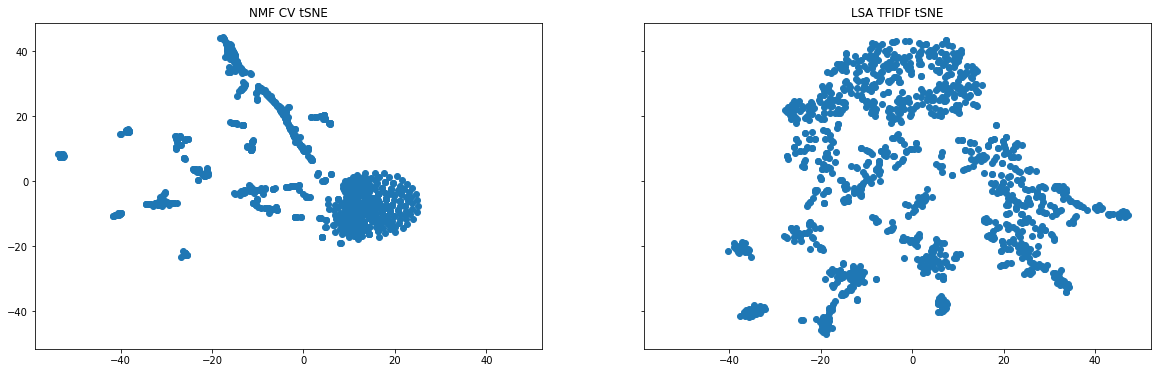

In [112]:
# Finding the right # of clusters using TSNE
tsne = TSNE(n_components = 2, perplexity = 30.0)
nm_cv_sne = tsne.fit_transform(nm_cv_data_W)
lsa_tfidf_sne = tsne.fit_transform(lsa_tfidf_data_w)

f, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,6))
f.subplots_adjust(hspace=0.3)

ax[0].set_title('NMF CV tSNE')
ax[0].plot(nm_cv_sne[:, 0], nm_cv_sne[:, 1],'o')
ax[1].set_title('LSA TFIDF tSNE')
ax[1].plot(lsa_tfidf_sne[:, 0], lsa_tfidf_sne[:, 1],'o')

In [114]:
def cluster_inertia(X_nmf, X_lsa, start, stop):
    inertia_lsa = [0,0]
    inertia_nmf = [0,0]

    for n_clusters in range(start, stop):
        km_nmf = KMeans(n_clusters = n_clusters)
        km_nmf.fit(X_nmf)
        msg_nmf = f"""# clusters: {n_clusters:2d}   Inertia: {km_nmf.inertia_:8.6f}"""
        inertia_nmf.append(km_nmf.inertia_)
        # print(msg_nmf)

        km_lsa = KMeans(n_clusters = n_clusters)
        km_lsa.fit(X_lsa)
        msg_lsa = f"""# clusters: {n_clusters:2d}   Inertia: {km_lsa.inertia_:8.6f}"""
        inertia_lsa.append(km_lsa.inertia_)
        # print(msg_lsa)

    f, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,6))
    f.subplots_adjust(hspace=0.3)

    ax[0].set_title('NMF Kmeans Inertia')
    ax[0].plot(inertia_nmf)
    ax[0].set_xlim([start, stop])
    ax[1].set_title('LSA Kmeans Inertia')
    ax[1].plot(inertia_lsa)
    ax[1].set_xlim([start, stop])

    return inertia_nmf, inertia_lsa

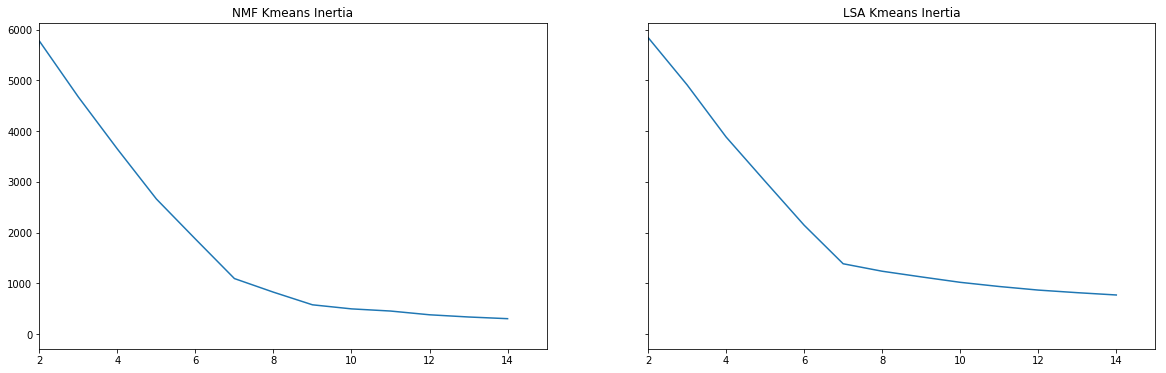

In [115]:
ssX = StandardScaler()
nm_cv_data_W_scaled = ssX.fit_transform(nm_cv_data_W)
lsa_tfidf_data_scaled = ssX.fit_transform(lsa_tfidf_data_w)
inertia_nmf, inertia_lsa = cluster_inertia(nm_cv_data_W_scaled, lsa_tfidf_data_scaled, 2, 15)
# Based on this result I will choose n_clusters = 6

In [116]:
def eval_kmeans(X, n_clusters):
    km = KMeans(n_clusters = n_clusters)
    km.fit(X)
    labels = km.predict(X)
    print(f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}     Silouette Score: {metrics.silhouette_score(X, labels)}""")
    return km.predict(X)

In [117]:
km_lsa = eval_kmeans(lsa_tfidf_data_scaled, n_clusters=6)
km_nmf = eval_kmeans(nm_cv_data_W_scaled, n_clusters=6)

# clusters:  6   Inertia: 2143.802424     Silouette Score: 0.8479029387332647
# clusters:  6   Inertia: 1871.593194     Silouette Score: 0.866369614284389


In [118]:
def tSNE_color(X_nmf, X_lsa, labels_nmf, labels_lsa):
    plt.figure(dpi=100)

    f, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,6))
    f.subplots_adjust(hspace=0.3)

    ax[0].set_title('tSNE on NMF topic space', size=25)
    ax[0].scatter(X_nmf[:, 0], X_nmf[:, 1], c=labels_nmf, alpha=0.5)
    ax[1].set_title('tSNE on LSA topic space', size=25)
    ax[1].scatter(X_lsa[:, 0], X_lsa[:, 1], c=labels_lsa, alpha=0.5)

<Figure size 600x400 with 0 Axes>

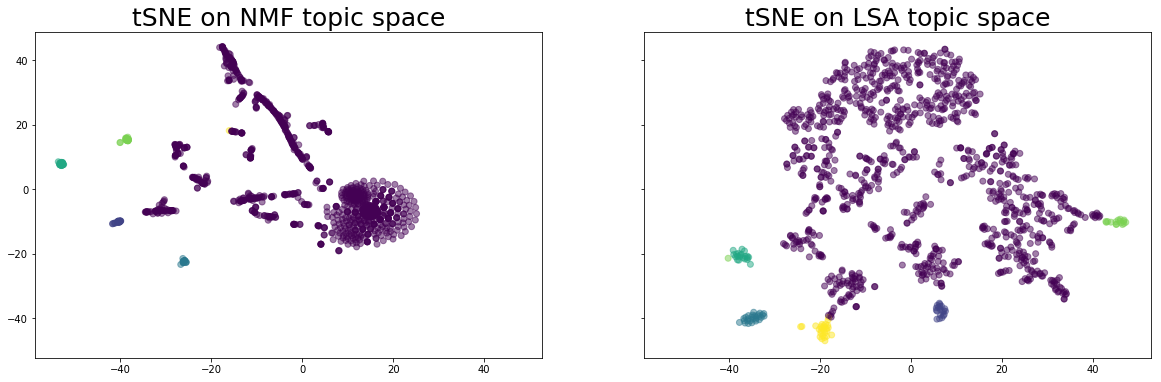

In [119]:
tSNE_color(nm_cv_sne, lsa_tfidf_sne, km_nmf, km_lsa)

__Look at the clusters__

In [55]:
def check_clusters(cleaned_data, labels, n):
    kmeans_labels = pd.concat([pd.DataFrame(cleaned_data), pd.DataFrame(labels)], axis=1)
    kmeans_labels.columns=['Answer', 'Label']
    counts = Counter(kmeans_labels['Label'])
    keys = list(counts.keys())
    print(counts)
    print()
    
    for i in range(len(keys)):
        print(kmeans_labels[kmeans_labels['Label']==keys[i]][:n])
    
    return kmeans_labels

In [56]:
kmeans_nmf_labels = check_clusters(cleaned_w, km_nmf, 5)
# Counter({0: 1055, 3: 27, 1: 25, 5: 24, 2: 22, 4: 1})
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==0][:5]
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==1] # Man
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==2] # People
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==3] # Sex
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==4] # ???
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==5] # Balls

Counter({0: 1055, 3: 27, 1: 25, 5: 24, 2: 22, 4: 1})

                  Answer  Label
0  coat hanger abortions      0
2        autocannibalism      0
3    vigorous jazz hands      0
4       flightless birds      0
5         pictures boobs      0
                            Answer  Label
1                         man meat      1
151                      folly man      1
190                       milk man      1
229  middle-aged man roller skates      1
284                   kool-aid man      1
                            Answer  Label
34            same-sex ice dancing      3
103                      panda sex      3
220                       sex life      3
228  collection high-tech sex toys      3
262         reciprocating oral sex      3
                            Answer  Label
79   eating cookies aids bake-sale      5
145          flesh-eating bacteria      5
186        eating last known bison      5
468                  eating albino      5
486          literally eating shit      

In [57]:
kmeans_lsa_labels = check_clusters(cleaned_w, km_lsa, 5)
# Counter({0: 1050, 1: 27, 5: 26, 4: 21, 3: 20, 2: 10})
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==0][:5]
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==1] # Sex
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==2] # Hot
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==3] # eating ass
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==4] # people
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==5] # man

Counter({0: 1050, 1: 27, 5: 26, 4: 21, 3: 20, 2: 10})

                  Answer  Label
0  coat hanger abortions      0
2        autocannibalism      0
3    vigorous jazz hands      0
4       flightless birds      0
5         pictures boobs      0
                            Answer  Label
1                         man meat      5
151                      folly man      5
190                       milk man      5
229  middle-aged man roller skates      5
284                   kool-aid man      5
                            Answer  Label
34            same-sex ice dancing      1
103                      panda sex      1
220                       sex life      1
228  collection high-tech sex toys      1
262         reciprocating oral sex      1
                            Answer  Label
79   eating cookies aids bake-sale      3
125                      whoop-ass      3
145          flesh-eating bacteria      3
186        eating last known bison      3
273                kids ass cancer     

__Look at only the Big Blob__

In [76]:
big_blob_nm = nm_cv_data_W_scaled[km_nmf==0]
big_blob_lsa = lsa_tfidf_data_scaled[km_lsa==0]
print(len(big_blob_nm), len(big_blob_lsa))

cleaned_bb_nm = np.asarray(cleaned_w)[km_nmf==0]
cleaned_bb_lsa = np.asarray(cleaned_w)[km_lsa==0]
print(len(cleaned_bb_nm), len(cleaned_bb_lsa))

1055 1050
1055 1050


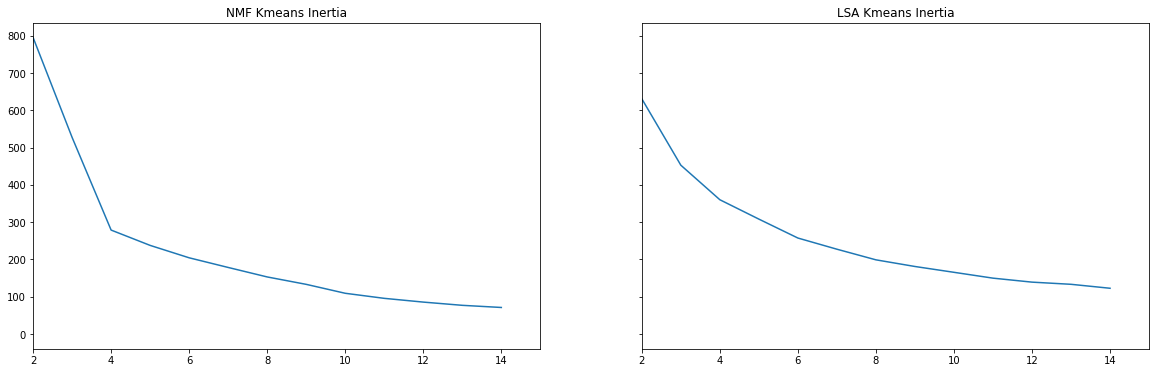

In [77]:
bb_iner_nmf, bb_iner_lsa = cluster_inertia(big_blob_nm, big_blob_lsa, 2, 15)

In [78]:
km_big_blob_nm = eval_kmeans(big_blob_nm, n_clusters=4)
km_big_blob_lsa = eval_kmeans(big_blob_lsa, n_clusters=4)
print("km_big_blob_nm:", Counter(km_big_blob_nm))
print("km_big_blob_lsa:", Counter(km_big_blob_lsa))

# clusters:  4   Inertia: 278.716903     Silouette Score: 0.8464310839596911
# clusters:  4   Inertia: 360.084207     Silouette Score: 0.7634139260700294
km_big_blob_nm: Counter({0: 977, 2: 58, 3: 10, 1: 10})
km_big_blob_lsa: Counter({0: 993, 2: 42, 1: 13, 3: 2})


In [79]:
big_blob_nm_sne = nm_cv_sne[km_nmf==0]
big_blob_lsa_sne = lsa_tfidf_sne[km_lsa==0]
print(len(big_blob_nm_sne), len(big_blob_lsa_sne))

1055 1050


<Figure size 600x400 with 0 Axes>

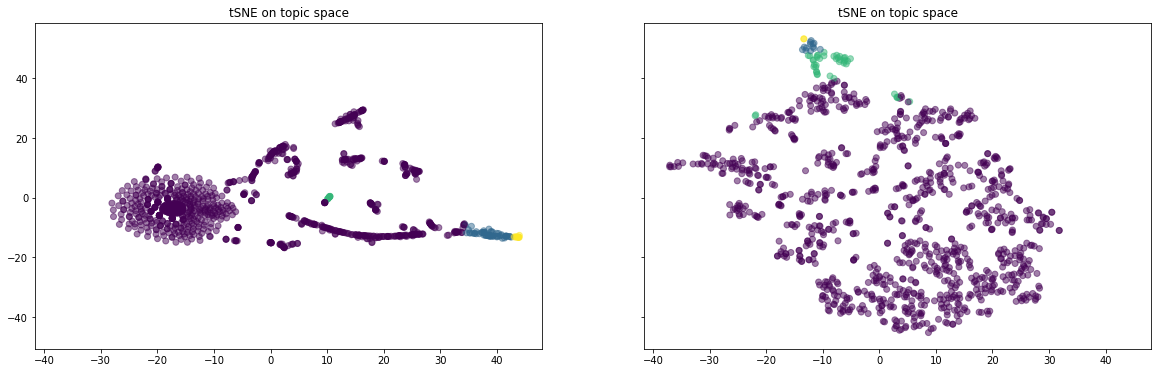

In [62]:
tSNE_color(big_blob_nm_sne, big_blob_lsa_sne, km_big_blob_nm, km_big_blob_lsa)

In [63]:
bb_nm_labels = check_clusters(cleaned_bb_nm, km_big_blob_nm, 5)
# km_big_blob_nm: Counter({1: 935, 0: 45, 3: 10, 2: 7})
# bb_nm_labels[bb_nm_labels['Label']==0] # Random
# bb_nm_labels[bb_nm_labels['Label']==1][:5] # dick penis 
# bb_nm_labels[bb_nm_labels['Label']==2] # balls
# bb_nm_labels[bb_nm_labels['Label']==3] # big black dick

Counter({0: 978, 1: 57, 2: 10, 3: 10})

                  Answer  Label
0  coat hanger abortions      0
1        autocannibalism      0
2    vigorous jazz hands      0
3       flightless birds      0
4         pictures boobs      0
                         Answer  Label
14                     big bang      1
63  historically black colleges      1
71                dick children      1
94                  dick cheney      1
95                   penis envy      1
                                              Answer  Label
118                                            balls      2
379        firing rifle air balls deep squealing hog      2
481                                   tripping balls      2
597  cat video cute eyes roll back spine slides anus      2
641                                 crazy opium eyes      2
                                              Answer  Label
489                                   big black dick      3
548                                   big black dick  

In [80]:
bb_lsa_labels = check_clusters(cleaned_bb_lsa, km_big_blob_lsa, 5)
# Counter({0: 993, 2: 42, 1: 13, 3: 2})
# bb_lsa_labels[bb_lsa_labels['Label']==0][:5] # Random
# bb_lsa_labels[bb_lsa_labels['Label']==1] # big dick, dick cheney 
# bb_lsa_labels[bb_lsa_labels['Label']==2] # hot, penis, 
# bb_lsa_labels[bb_lsa_labels['Label']==3] # Big black dick

Counter({0: 993, 2: 42, 1: 13, 3: 2})

                  Answer  Label
0  coat hanger abortions      0
1        autocannibalism      0
2    vigorous jazz hands      0
3       flightless birds      0
4         pictures boobs      0
                          Answer  Label
14                      big bang      1
63   historically black colleges      1
71                 dick children      1
94                   dick cheney      1
104            sassy black woman      1
                               Answer  Label
95                         penis envy      2
111           toni morrison 's vagina      2
188                        good sniff      2
194    jerking pool children 's tears      2
210  snapping turtle biting tip penis      2
             Answer  Label
483  big black dick      3
542  big black dick      3


#### DB Scan

In [65]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [66]:
X_lsa_tfidf_data_w = StandardScaler().fit_transform(lsa_tfidf_data_w)
X_nm_cv_data_W = StandardScaler().fit_transform(nm_cv_data_W)

In [67]:
def eval_dbscan(X, eps, min_samples):
    clusters = []
    silhouette_scores = []
    for i in range(len(eps)):
        # Compute DBSCAN
        db = DBSCAN(eps=eps[i], min_samples=min_samples).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        clusters.append(n_clusters_)
        silhouette_scores.append(metrics.silhouette_score(X, labels))
    return pd.DataFrame(list(zip(eps, clusters, silhouette_scores)), columns=['eps', 'clusters', 'silhouette_scores'])

                 0  eps  clusters  silhouette_scores
23  X_nm_cv_data_W  2.4         5           0.867083
21  X_nm_cv_data_W  2.2         5           0.866202
22  X_nm_cv_data_W  2.3         5           0.866202
20  X_nm_cv_data_W  2.1         5           0.861899
19  X_nm_cv_data_W  2.0         5           0.861899


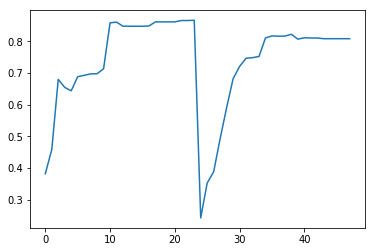

In [68]:
eps = np.arange(0.1, 2.5, 0.1)
min_samples=3
name = ['X_nm_cv_data_W']*len(eps) + ['X_lsa_tfidf_data_w']*len(eps)
X = [X_nm_cv_data_W, X_lsa_tfidf_data_w]

db_nm = eval_dbscan(X_nm_cv_data_W, eps, min_samples)
db_lsa = eval_dbscan(X_lsa_tfidf_data_w, eps, min_samples)
db_all = pd.concat([db_nm, db_lsa], axis=0).reset_index()
db_all = pd.merge(pd.DataFrame(name), db_all, left_index=True, right_index=True)
db_all.drop(labels = ['index'], axis=1, inplace=True)
print(db_all.sort_values(by='silhouette_scores', ascending = False)[:5])

plt.plot(db_all['silhouette_scores'])
# Based on this results, I pick eps=2.3, X_nm_cv_data_W

Estimated number of clusters: 5
Silhouette Coefficient: 0.866


Text(0.5,1,'Estimated number of clusters: 5')

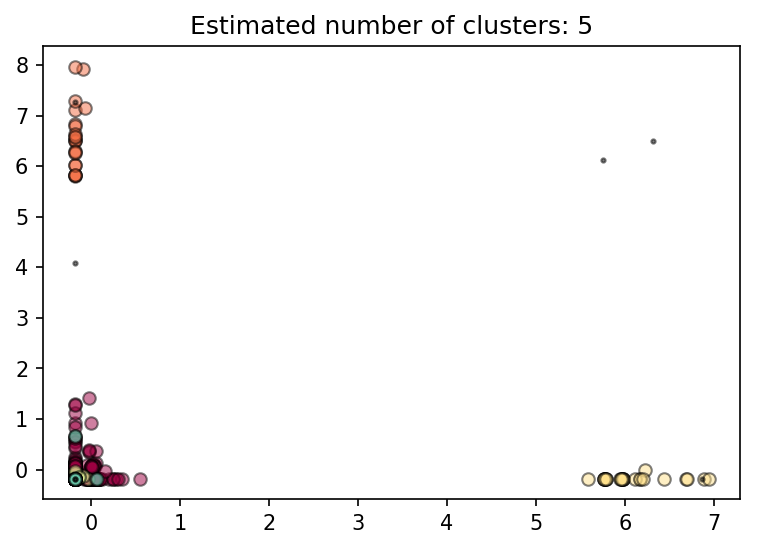

In [69]:
# Compute DBSCAN and Plot the Chosen parameters
X = X_nm_cv_data_W
eps=2.3
min_samples=3
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X, labels))

plt.figure(dpi=150)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, alpha=0.5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2, alpha=0.5)

plt.title('Estimated number of clusters: %d' % n_clusters_)

Counter({0: 1054, 2: 27, 3: 24, 1: 22, 4: 20, -1: 7})


(array([   7., 1054.,   22.,   27.,   44.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.]),
 <a list of 5 Patch objects>)

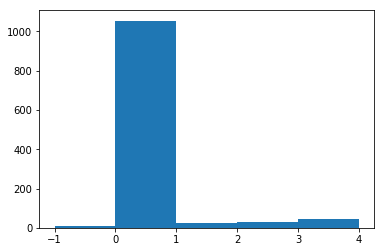

In [70]:
print(Counter(labels))
plt.hist(labels, bins=5)

In [81]:
dbscan_labels = check_clusters(cleaned_w, labels, 5)
# Counter({0: 1054, 2: 27, 3: 24, 1: 22, 4: 20, -1: 7})
# dbscan_labels = pd.concat([pd.DataFrame(cleaned_w), pd.DataFrame(labels)], axis=1)
# dbscan_labels.columns=['Answer', 'Label']
# dbscan_labels[dbscan_labels['Label']==0][:20]
# dbscan_labels[dbscan_labels['Label']==1] #Man
# dbscan_labels[dbscan_labels['Label']==2] #Sex
# dbscan_labels[dbscan_labels['Label']==3] #Eating and like
# dbscan_labels[dbscan_labels['Label']==4] #People
# dbscan_labels[dbscan_labels['Label']== -1] #F-ed up violence

Counter({0: 1054, 2: 27, 3: 24, 1: 22, 4: 20, -1: 7})

                  Answer  Label
0  coat hanger abortions      0
2        autocannibalism      0
3    vigorous jazz hands      0
4       flightless birds      0
5         pictures boobs      0
                            Answer  Label
1                         man meat      1
151                      folly man      1
190                       milk man      1
229  middle-aged man roller skates      1
284                   kool-aid man      1
                            Answer  Label
34            same-sex ice dancing      2
103                      panda sex      2
220                       sex life      2
228  collection high-tech sex toys      2
262         reciprocating oral sex      2
                            Answer  Label
79   eating cookies aids bake-sale      3
145          flesh-eating bacteria      3
186        eating last known bison      3
468                  eating albino      3
486          literally eating shit     

#### Not using

In [ ]:
# For Visualization
n_comp = 10
pca_cv = TruncatedSVD(n_components=n_comp)
pca_cv_data_W = pca_cv.fit_transform(cv_w)
print(pca_cv.explained_variance_ratio_)  
print(pca_cv.singular_values_) 
print(pca_cv.components_.shape)

f, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,6))
f.subplots_adjust(hspace=0.3)

ax[0].set_title('PCA Components')
ax[0].plot(pca_cv.components_[0, :], pca_cv.components_[1, :], 'o', alpha=0.5)
ax[1].set_title('PCA Out Matrix')
ax[1].plot(pca_cv_data_W[:,0], pca_cv_data_W[:,1], 'o', alpha=0.5)

In [ ]:
# For Visualization
n_clusters = 10
km2 = KMeans(n_clusters = n_clusters)
km2.fit(pca_cv_data_W)
print(Counter(km2.labels_))

plt.title('PCA Out Matrix')
plt.scatter(pca_cv_data_W[:,0], pca_cv_data_W[:,1], c=km2.labels_, alpha=0.5)

## RNN
See complete RNN analysis in Part II and III notebooks 

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [41]:
print(len(w2v_pred_words_flat)) # Length of vocab
print(len(w2v_pred_words_flat[1]))

1465
5


In [42]:
word_to_ix = {}
for sent in w2v_pred_words_flat:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

In [43]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [44]:
inputs = [prepare_sequence(sent, word_to_ix) for sent in w2v_pred_words_flat]
print(len(inputs))
inputs[0]

1465


tensor([0, 1, 2, 3, 4])

In [45]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, vocab_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [46]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [103]:
# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
ix=0
with torch.no_grad():
    inputs = prepare_sequence(w2v_pred_words_flat[ix], word_to_ix)
    tag_scores = model(inputs)
#     print(tag_scores[:3])

print(w2v_pred_words_flat[ix]) 
print(len(w2v_pred_words_flat[ix])) # 4 words
print(len(inputs))                  # 4 inputs
print(len(tag_scores))              # 4 tag scores
print(len(tag_scores[0]))           # 2375 vocab and 2375 tensors
print(len(word_to_ix))
# print()
# for i in range(len(tag_scores)):   # 2400 tensors for each
#     print(len(tag_scores[i]))
pre_train = [s.argmax() for s in tag_scores]
pre_train[:5]

['sleep', 'night', '?', 'mutually-assured', 'destruction']
5
5
5
2375
2375


[tensor(1913), tensor(240), tensor(2), tensor(143), tensor(499)]

In [90]:
print(word_to_ix)

{'sleep': 0, 'night': 1, '?': 2, 'mutually-assured': 3, 'destruction': 4, 'blowing': 5, 'dudes': 6, 'alley': 7, 'civilian': 8, 'casualties': 9, 'beating': 10, 'wives': 11, 'bees': 12, '99': 13, 'problems': 14, '_': 15, 'one': 16, '40': 17, 'acres': 18, 'mule': 19, 'content': 20, 'harry': 21, 'potter': 22, 'erotica': 23, '10': 24, 'incredible': 25, 'facts': 26, 'anus': 27, 'ring': 28, 'rule': 29, 'girl': 30, "'s": 31, 'best': 32, 'friend': 33, 'shaft': 34, 'extremely': 35, 'tight': 36, 'pants': 37, 'jewish': 38, 'fraternities': 39, 'multiple': 40, 'stab': 41, 'wounds': 42, 'smell': 43, 'fuck': 44, 'mountain': 45, 'foul': 46, 'mouth': 47, 'great': 48, 'ass': 49, 'looks': 50, 'jeans': 51, 'centaurs': 52, 'way': 53, 'world': 54, 'ends': 55, '/': 56, 'bang': 57, 'spectacular': 58, 'abs': 59, 'fear': 60, 'barack': 61, 'obama': 62, 'erection': 63, 'lasts': 64, 'long': 65, 'four': 66, 'hours': 67, 'giving': 68, 'shit': 69, 'third': 70, 'batman': 71, 'guilty': 72, 'pleasure': 73, 'defeating': 7

In [104]:
training_data = w2v_pred_words_flat
loss_agg=[]
for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(sentence, word_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss_agg.append(loss)
        loss.backward()
        optimizer.step()

In [105]:
# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

tensor([[ -3.1078, -19.6053, -37.3029,  ..., -17.3504,  -9.8487, -12.1984],
        [-15.3889,  -0.7530, -21.0150,  ..., -15.1221, -17.3495, -16.0186],
        [-28.0851, -18.2300,  -0.0084,  ..., -14.5953, -20.6668, -17.9007],
        [-10.5000,  -4.8704, -20.1353,  ..., -12.1903, -11.4408, -12.0544],
        [-15.7441, -16.8559, -23.6125,  ..., -15.9360, -14.9786, -17.9939]])


In [106]:
ix=0
print(w2v_pred_words_flat[ix]) 
post_train = [s.argmax() for s in tag_scores[ix]]
print(post_train[:5])

['sleep', 'night', '?', 'mutually-assured', 'destruction']
[tensor(0), tensor(0), tensor(0), tensor(0), tensor(0)]


In [108]:
print(pre_train[:5])
# print(next_w[:5])
# print(post_train[:5])

[tensor(1913), tensor(240), tensor(2), tensor(143), tensor(499)]


In [110]:
print([key  for (key, value) in word_to_ix.items() if value == 1913])
print([key  for (key, value) in word_to_ix.items() if value == 2])
print([key  for (key, value) in word_to_ix.items() if value == 143])
print([key  for (key, value) in word_to_ix.items() if value == 499])

['#']
['?']
['hot']
['art']


In [ ]:
plt.plot(range(len(loss_agg)), loss_agg)

__Keras__  
__sequences__: this list contains the sequences of words (i.e. a list of words) used to train the model,  
__next_words__: this list contains the next words for each sequences of the sequences list.  
1. X : the matrix of the following dimensions:  
    - number of sequences,
    - number of words in sequences,
    - number of words in the vocabulary.
2. y : the matrix of the following dimensions:
    - number of sequences,
    - number of words in the vocabulary.

In [625]:
# #import Keras library
# from keras.models import Sequential, Model
# from keras.layers import Dense, Activation, Dropout
# from keras.layers import LSTM, Input, Bidirectional
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# from keras.metrics import categorical_accuracy

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
